In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random
import cv2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import cv2 # Not directly used for image loading anymore but kept if you use it elsewhere
from sklearn.model_selection import train_test_split # Not needed for dataset split anymore
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Import callbacks

tf.random.set_seed(42)
np.random.seed(42)



In [3]:
# Define base directory and target split ratios
base_dir = 'd:/deepfake/Celeb-DF-New'
output_dir = 'd:/deepfake/split_data'
split_ratios = {'train': 0.6, 'valid': 0.2, 'test': 0.2}

# Create output directories
for split in split_ratios.keys():
    for label in ['Real', 'Fake']:
        Path(f"{output_dir}/{split}/{label}").mkdir(parents=True, exist_ok=True)

# Function to split and copy images
def split_images(label, label_dir):
    # Get all images in the label directory
    images = os.listdir(label_dir)
    random.shuffle(images)  # Shuffle images

    # Calculate split sizes
    total_images = len(images)
    train_size = int(split_ratios['train'] * total_images)
    valid_size = int(split_ratios['valid'] * total_images)

    # Split images
    train_images = images[:train_size]
    valid_images = images[train_size:train_size + valid_size]
    test_images = images[train_size + valid_size:]

    # Function to copy files to output directory
    def copy_images(image_list, split):
        for img in image_list:
            src = os.path.join(label_dir, img)
            dest = os.path.join(output_dir, split, label, img)
            shutil.copy(src, dest)

    # Copy images to respective directories
    copy_images(train_images, 'train')
    copy_images(valid_images, 'valid')
    copy_images(test_images, 'test')

# Split and copy images for both labels
for label in ['Real', 'Fake']:
    label_dir = os.path.join(base_dir, label)
    split_images(label, label_dir)

print("Images have been split and saved to:", output_dir)

KeyboardInterrupt: 

In [4]:
# Define base directories and split ratios
main_path = 'd:/deepfake//real_vs_fake/real-vs-fake'
second_main_path = 'd:/deepfake/deepfake-and-real-images/Dataset'
third_main_path = 'd:/deepfake/split_data'  # Celeb-DF-New after splitting

# Standardized subdirectory names for datasets
sub_dirs_mapping = {
    'train': ['train', 'Train', 'train'],  # Train for Deepfake, train for others
    'valid': ['valid', 'Validation', 'valid'],  # Validation for Deepfake, valid for others
    'test': ['test', 'Test', 'test']  # Test for Deepfake, test for others
}

# Label mapping for real and fake folders
label_mapping = {'Real': 1, 'Fake': 0, 'real': 1, 'fake': 0}

# Function to create a DataFrame for a given base path and subdirectory
def create_dataframe(base_path, sub_dir, label_map):
    data = {"file_path": [], "label": []}
    for label_dir, label in label_map.items():  # Iterate over 'Real' and 'Fake'
        folder_path = os.path.join(base_path, sub_dir, label_dir)
        if os.path.exists(folder_path):  # Ensure the folder exists
            for img_file in os.listdir(folder_path):
                if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):  # Only process image files
                    data["file_path"].append(os.path.join(folder_path, img_file))
                    data["label"].append(label)
    return pd.DataFrame(data)

# Combine data from all datasets for train, valid, and test
for split_key, sub_dirs in sub_dirs_mapping.items():
    combined_data = pd.DataFrame()  # Empty DataFrame to hold all data for this split

    # Process 140K dataset
    df_140k = create_dataframe(main_path, sub_dirs[0], label_mapping)
    combined_data = pd.concat([combined_data, df_140k], ignore_index=True)

    # Process Deepfake dataset
    df_deepfake = create_dataframe(second_main_path, sub_dirs[1], label_mapping)
    combined_data = pd.concat([combined_data, df_deepfake], ignore_index=True)

    # Process Celeb-DF-New dataset
    df_celeb = create_dataframe(third_main_path, sub_dirs[2], label_mapping)
    combined_data = pd.concat([combined_data, df_celeb], ignore_index=True)

    # Save the combined data to CSV
    csv_path = f"d:/deepfake/{split_key}.csv"
    combined_data.to_csv(csv_path, index=False)
    print(f"Saved {csv_path} with {len(combined_data)} entries.")

Saved d:/deepfake/train.csv with 262532 entries.
Saved d:/deepfake/valid.csv with 100412 entries.
Saved d:/deepfake/test.csv with 100408 entries.


In [5]:
# --- NEW DATASET LOADING FROM CSVs ---
train_df = pd.read_csv("train.csv") # Load train CSV
valid_df = pd.read_csv("valid.csv") # Load valid CSV
test_df = pd.read_csv("test.csv")   # Load test CSV

train_df['label'] = train_df['label'].astype(str) # Ensure label is string type (as in DenseNet121 code)
valid_df['label'] = valid_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

IMAGE_SIZE = (224, 224) # Define image size, matching your model input
BATCH_SIZE = 32 # Define batch size



In [6]:
# --- DATA GENERATORS USING DATAFRAMES ---
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0) # Use separate datagen for validation/test (no augmentation)

train_flow = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',      # Path to images is in 'file_path' column
    y_col='label',         # Labels are in 'label' column
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'    # Binary classification (real/fake)
)

val_flow = val_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False          # No need to shuffle validation data
)

test_flow = val_datagen.flow_from_dataframe( # Using val_datagen for test as well (no augmentation)
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False          # No need to shuffle test data
)




Found 262532 validated image filenames belonging to 2 classes.
Found 100412 validated image filenames belonging to 2 classes.
Found 100408 validated image filenames belonging to 2 classes.


In [7]:

# --- MODEL DEFINITION (LFAT - No changes needed here unless you want to adjust architecture) ---
def transformer_encoder(inputs, num_heads, key_dim, ffn_dim, num_layers):
    x = inputs
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
        x = layers.Add()([x, attn_output])
        x = layers.LayerNormalization()(x)
        ffn_output = layers.Dense(ffn_dim, activation='relu')(x)
        ffn_output = layers.Dense(inputs.shape[-1])(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization()(x)
    return x



In [8]:
class FrequencyAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FrequencyAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        cnn_feature_shape, freq_map_shape = input_shape
        self.channel_attention = layers.Dense(cnn_feature_shape[-1], activation='sigmoid') # Learn channel weights

    def call(self, inputs):
        cnn_features, freq_map = inputs

        # Global Average Pooling on Frequency Map
        frequency_attention_vector = tf.keras.layers.GlobalAveragePooling2D()(freq_map) # Shape (B, 1, 1) or (B, 1)

        # Learnable Transformation (FC layer to get channel weights)
        attention_weights = self.channel_attention(frequency_attention_vector) # Output shape (B, C), C = num_channels of cnn_features

        # Channel-wise Multiplication - Reshape weights to be broadcastable
        attention_weights = tf.reshape(attention_weights, (-1, 1, 1, cnn_features.shape[-1])) # Shape (B, 1, 1, C)

        # Apply attention to CNN features
        attended_cnn_features = cnn_features * attention_weights # Broadcasting will handle channel-wise multiplication
        return attended_cnn_features

class FrequencyTransformLayer(tf.keras.layers.Layer):
    def __init__(self, resize_shape=(224, 224), **kwargs):
        super(FrequencyTransformLayer, self).__init__(**kwargs)
        self.resize_shape = resize_shape  # Resize the frequency map to this shape

    def call(self, inputs):
        # Convert RGB to grayscale
        gray_image = tf.image.rgb_to_grayscale(inputs)

        # Compute 2D Fourier Transform (FFT) using TensorFlow
        fft = tf.signal.fft2d(tf.cast(gray_image, tf.complex64))

        # Calculate the Magnitude Spectrum
        magnitude_spectrum = tf.math.log1p(tf.abs(fft))

        # Resize the magnitude spectrum to match the CNN feature map size
        magnitude_spectrum_resized = tf.image.resize(
            magnitude_spectrum,
            self.resize_shape,
            method='bilinear'  # Bilinear interpolation
        )

        return magnitude_spectrum_resized



In [9]:
def build_lfat(input_shape=(224, 224, 3), freq_resize_shape=(7, 7)):  # Resize the frequency map to 7x7
    # Input layer
    image_input = layers.Input(shape=input_shape)

    # CNN Backbone (MobileNetV2)
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the backbone initially
    cnn_features = base_model(image_input)  # Shape (B, 7, 7, 1280)

    # Frequency Transformation
    freq_transform_layer = FrequencyTransformLayer(resize_shape=freq_resize_shape)(image_input)  # Use resized frequency map

    # Frequency-Aware Attention
    freq_attention = FrequencyAttentionLayer()([cnn_features, freq_transform_layer])

    # Transformer Encoder
    reshaped_features = layers.Reshape((-1, freq_attention.shape[-1]))(freq_attention)
    transformer_output = transformer_encoder(reshaped_features, num_heads=4, key_dim=64, ffn_dim=128, num_layers=2)

    # Classification Head
    pooled_features = layers.GlobalAveragePooling1D()(transformer_output)
    output = layers.Dense(1, activation='sigmoid')(pooled_features)

    return models.Model(inputs=image_input, outputs=output)



In [11]:
lfat_model = build_lfat(freq_resize_shape=(7, 7))
lfat_model.compile(optimizer=optimizers.AdamW(learning_rate=0.0001),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])



In [22]:
lfat_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_3[0][0]']             
 tional)                                                                                          
                                                                                                  
 frequency_transform_layer_  (None, 7, 7, 1)              0         ['input_3[0][0]']             
 1 (FrequencyTransformLayer                                                                       
 )                                                                                          

In [12]:
# --- CALLBACKS FOR FINE-TUNING ---
checkpoint_path = "d:/deepfake/LFAT_best_model678.h5" # Path to save best model
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",      # Monitor validation accuracy
    save_best_only=True,         # Save only the best model
    mode="max",                  # 'max' because we want to maximize accuracy
    verbose=1
)

In [13]:


early_stopping = EarlyStopping(
    monitor="val_loss",          # Monitor validation loss
    patience=5,                 # Stop after 5 epochs with no improvement
    restore_best_weights=True,   # Restore weights from the epoch with the best val_loss
    verbose=1
)

# --- TRAINING WITH DATA GENERATORS AND CALLBACKS ---
history = lfat_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=25, # Or more, EarlyStopping will stop it if needed
    verbose=1,
    callbacks=[model_checkpoint, early_stopping] # Add callbacks here
)



Epoch 1/25
8205/8205 [==============================] - ETA: 0s - loss: 0.3679 - accuracy: 0.8285
Epoch 1: val_accuracy improved from -inf to 0.91376, saving model to d:/deepfake\LFAT_best_model678.h5


d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8205/8205 [==============================] - 8439s 1s/step - loss: 0.3679 - accuracy: 0.8285 - val_loss: 0.1991 - val_accuracy: 0.9138
Epoch 2/25
8205/8205 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8749
Epoch 2: val_accuracy improved from 0.91376 to 0.91887, saving model to d:/deepfake\LFAT_best_model678.h5
8205/8205 [==============================] - 8325s 1s/step - loss: 0.2838 - accuracy: 0.8749 - val_loss: 0.1896 - val_accuracy: 0.9189
Epoch 3/25
8205/8205 [==============================] - ETA: 0s - loss: 0.2512 - accuracy: 0.8916
Epoch 3: val_accuracy did not improve from 0.91887
8205/8205 [==============================] - 8392s 1s/step - loss: 0.2512 - accuracy: 0.8916 - val_loss: 0.2158 - val_accuracy: 0.9129
Epoch 4/25
8205/8205 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9010
Epoch 4: val_accuracy improved from 0.91887 to 0.92792, saving model to d:/deepfake\LFAT_best_model678.h5
8205/8205 [===========================

In [14]:
# --- LOAD BEST MODEL WEIGHTS ---
lfat_model.load_weights(checkpoint_path) # Load the best weights saved by ModelCheckpoint

# --- EVALUATION ON TEST SET USING TEST GENERATOR ---
test_loss, test_accuracy = lfat_model.evaluate(test_flow, verbose=1) # Evaluate using test_flow
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# --- EVALUATION METRICS (PREDICT USING GENERATOR) ---
y_pred_prob = lfat_model.predict(test_flow) # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype(int)      # Convert probabilities to binary predictions
y_test = test_flow.classes                     # Get true labels from test_flow

print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_prob):.4f}") # Use probabilities for AUC



3138/3138 [==============================] - 1564s 498ms/step - loss: 0.1406 - accuracy: 0.9457
Test Loss: 0.1406
Test Accuracy: 94.57%
3138/3138 [==============================] - 1565s 498ms/step
F1 Score: 0.9291
Precision: 0.8965
Recall: 0.9641
AUC: 0.9909


In [15]:
lfat_model.save('lfattunedaccuracy14032025.h5')

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


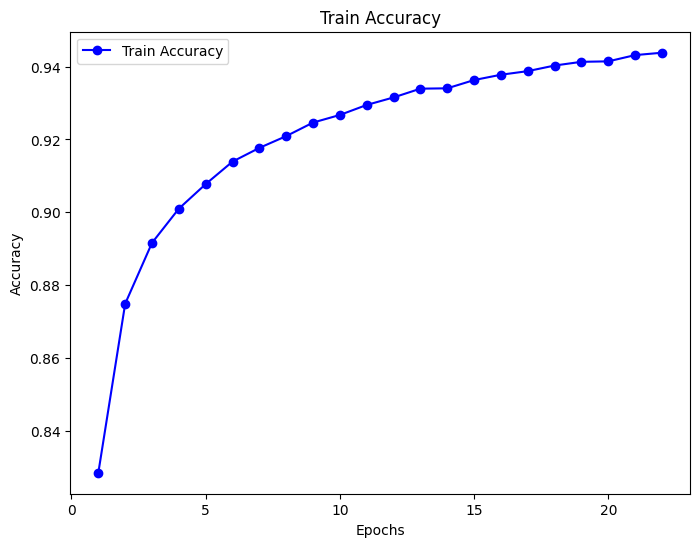

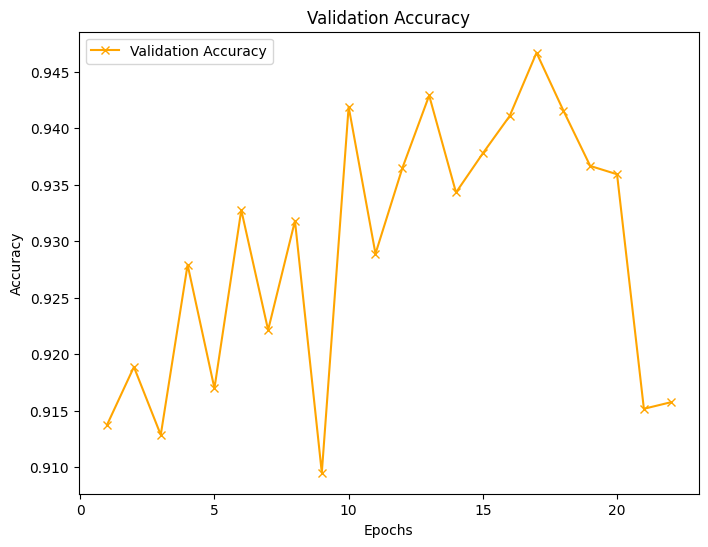

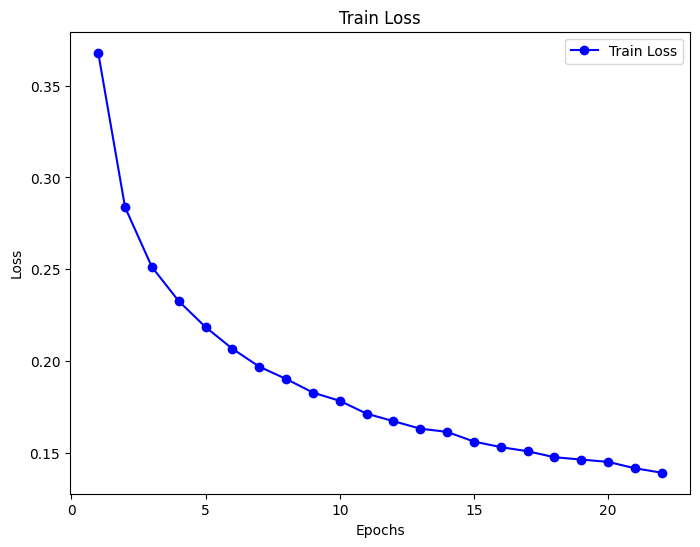

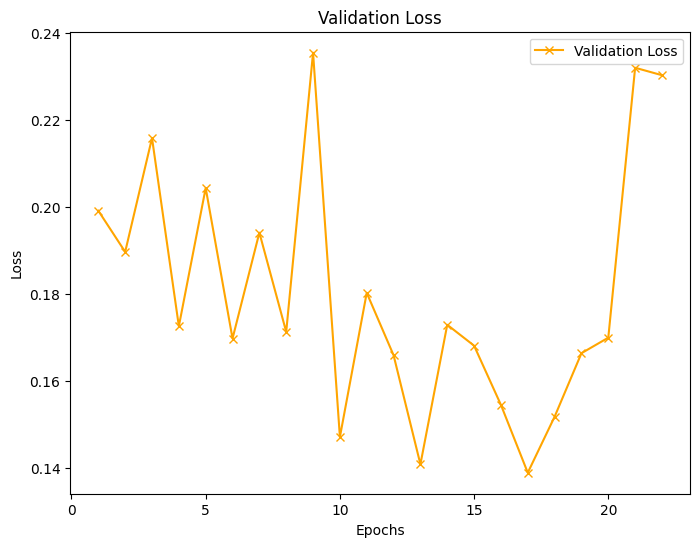

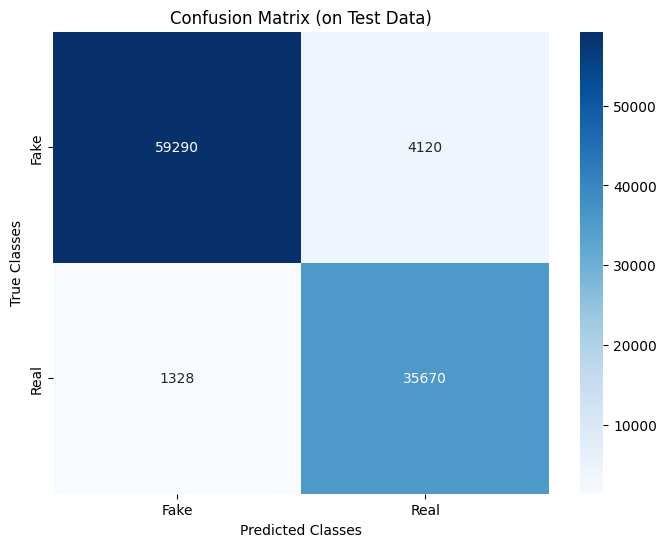

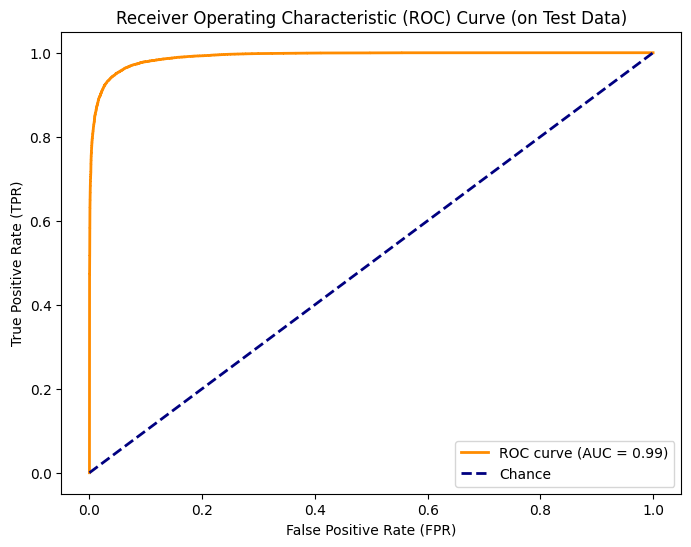

d:\anaconda3\envs\tf213_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as lfat_model_tuned.h5


In [21]:
# --- PLOT TRAINING HISTORY (Separate Windows for Blue and Orange Lines) ---

epochs_range = range(1, len(history.epoch) + 1)

# Plot Train Accuracy in a separate blue window
plt.figure(figsize=(8, 6)) # Create a new figure for Train Accuracy
acc = history.history['accuracy']
plt.plot(epochs_range, acc, label='Train Accuracy', color='blue', marker='o')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.show() # Show Train Accuracy in a separate window

# Plot Validation Accuracy in a separate orange window
plt.figure(figsize=(8, 6)) # Create a new figure for Validation Accuracy
val_acc = history.history['val_accuracy']
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='x')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show() # Show Validation Accuracy in a separate window


# Plot Train Loss in a separate blue window
plt.figure(figsize=(8, 6)) # Create a new figure for Train Loss
loss = history.history['loss']
plt.plot(epochs_range, loss, label='Train Loss', color='blue', marker='o')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.show() # Show Train Loss in a separate window

# Plot Validation Loss in a separate orange window
plt.figure(figsize=(8, 6)) # Create a new figure for Validation Loss
val_loss = history.history['val_loss']
plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='x')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show() # Show Validation Loss in a separate window


# --- CONFUSION MATRIX ---

# Use y_test and y_pred calculated above for confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Define class labels for the confusion matrix
class_labels = ['Fake', 'Real']  # Assuming 0: Fake, 1: Real. Verify from your data if needed.

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(8, 6)) # New figure for confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, # Set x-axis labels to class names
            yticklabels=class_labels) # Set y-axis labels to class names
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix (on Test Data)') # Updated title to indicate test data
plt.show() # Show confusion matrix in a separate window


# --- ROC CURVE (For Binary Classification - Adjust if multi-class) ---
# ROC curve is typically for binary classification.
# If you have multi-class, you might need to do one-vs-rest ROC curves for each class.

# Assuming binary classification as per your prediction threshold (0.5)
if y_pred_prob.shape[1] == 1 or y_pred_prob.shape[1] == 2: # Assuming 1 output or 2 outputs for binary
    if y_pred_prob.shape[1] == 2: # if 2 outputs, take probability of the positive class (index 1)
        y_scores = y_pred_prob[:, 1]
    else: # if 1 output, assume it's probability of positive class
        y_scores = y_pred_prob[:, 0]

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6)) # New figure for ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance') # Chance line
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve (on Test Data)') # Updated title to indicate test data
    plt.legend(loc="lower right")
    plt.show() # Show ROC curve in a separate window
else:
    print("ROC Curve is typically for binary classification. For multi-class, consider One-vs-Rest ROC curves.")


lfat_model.save("lfat_model_tuned.h5")
print("Model saved as lfat_model_tuned.h5")